#### Functions (IGNORE)

In [1]:
# import packages that will be used for analysis
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

##### Get Stock Data

In [2]:
import yfinance as yf
missing_data_tickers = [] # use this as a list of tickers with missing data

def get_data_from_start_to_end(ticker, start_date, end_date):
    global missing_data_tickers  # Use the global list to accumulate missing tickers
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        if stock_data.empty:
            missing_data_tickers.append(ticker)
            raise ValueError(f"Stock data for ticker {ticker} during the period from {start_date} to {end_date} was not found.")
        return stock_data
    except Exception as e:
        print(f"An error occurred for ticker {ticker}: {e}")
        missing_data_tickers.append(ticker)
        return None


In [3]:
# for a variety of periods load in different list of tickers
def download_stock_data_for_periods(tickers, periods):
    all_data = {}
    
    for period, (start_date, end_date) in periods.items():
        period_data = {}
        for ticker in tickers:
            data = get_data_from_start_to_end(ticker, start_date, end_date)
            if data is not None:
                period_data[ticker] = data
        all_data[period] = period_data
    
    return all_data

In [4]:
import pandas as pd

# Get the adjusted close prices
adj_close_sector_etf = {}

# Create adjusted close price only listing of sector ETFs
def get_adjusted_closed_price(nested_dict, tickers, periods):
    for period in periods:
        stock_price_df = pd.DataFrame()  # Create a new DataFrame for each period
        for ticker in tickers:
            stock_price_df[ticker] = nested_dict[period][ticker]['Adj Close']
        
        adj_close_sector_etf[period] = stock_price_df  # Store the complete DataFrame for the period
    
    return adj_close_sector_etf

##### Stochastic Modeling

In [5]:
def stochastic_modeling(nested_dict, tickers, periods,num_samples,investment_period):
    # Store the returns in a nested dictionary
    nested_dict_returns = {period: {ticker: [] for ticker in tickers} for period in periods}

    # Go through each economic time period
    for period in periods:
        max_index = len(nested_dict[period]) - investment_period  # Ensure there's enough data to calculate ROI

        # Generate random samples from the valid range
        random_dates = random.choices(range(max_index), k=num_samples)

        for ticker in tickers:
            for date_idx in random_dates:
                start_price = nested_dict[period][ticker].iloc[date_idx]
                end_price = nested_dict[period][ticker].iloc[date_idx + investment_period]

                # Get the return by the Holding Period Return
                roi = (((end_price - start_price) / start_price) * 100)

                nested_dict_returns[period][ticker].append(roi)

    return nested_dict_returns  # Return the nested dictionary with returns

In [6]:
def stochastic_roi(tickers,periods,return_rates_list,analysis_type):
    df = pd.DataFrame(index=tickers,columns=periods)
    for period in periods:
        for ticker in tickers:
            data = pd.Series(return_rates_list[period][ticker])
            if analysis_type=='Mean':
                df.at[ticker,period] = data.mean()
            elif analysis_type=='Median':
                df.at[ticker,period] = data.median()
            elif analysis_type=='Std':
                df.at[ticker,period] = data.std()
            elif analysis_type=='Variance':
                df.at[ticker,period] = data.var()

    return df

##### Plot Data

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot percentage-based histogram
def plot_percentage_histogram(data, title, xlabel, ylabel, bins=10, color='skyblue'):
    """
    Plots a percentage-based histogram for the given data.

    Parameters:
    data (array-like): Data to plot the histogram for.
    title (str): Title of the plot.
    xlabel (str): Label for the x-axis.
    ylabel (str): Label for the y-axis.
    bins (int): Number of bins for the histogram.
    color (str): Color for the histogram bars.
    """
    # Set modern aesthetic
    sns.set_style("whitegrid")

    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins, color=color, edgecolor='black',
             weights=np.ones_like(data) / len(data))

    # Convert y-axis to percentages
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

    # Add titles and labels with improved font sizes
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    # Add gridlines for better readability
    plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

# Chapter 1: Buy and Hold Strategy
A Buy and Hold Strategy is an investment approach where an investor purchases stocks or other assets and holds onto them for an extended period, regardless of short-term market fluctuations. This strategy operates on the assumption that, over time, the market tends to increase in value, thus yielding returns on investments held over years. It's particularly popular among novice investors for its simplicity and potential to minimize the stress of frequent trading decisions.

## Buy and Hold Strategy using Sector ETF's
Sector ETFs are the accumulation of a variety of stocks within one of the 11 GICS Sectors (see documentation). They are meant to be a representation of a sector's overall movement. This will allow for a better understanding of which sectors perform best over time. To add further complexity, different economic time periods will be used to evaluate the changing success of an investment based on macroeconomic environments. For example some stocks out perform benchmarks during a recession due to their defensive nature such as the Health Care ETF (XLV).

## Sector ETF and Time Period Setup

In [8]:
# create time periods for where this takes place
economic_cycle_periods = {

    "trough": ("2008-10-01", "2009-06-01"),
    "expansion": ("2012-01-01", "2015-01-01"),
    "peak": ("2019-06-01", "2020-02-01"),
    "contraction": ("2007-12-01", "2008-10-01"),
    'all_data': ('2005-01-01','2024-06-01')
}

economic_cycle_periods_list = ['trough','expansion','peak','contraction','all_data']

In [9]:
# create etf tickers for sectors
sector_etf_tickers = [
    'XLB', # materials sector
    'XLI', # industrials sector
    'XLF', # financials
    'XLK', # information technology
    'XLY', # consumer discretionary
    'XLP', # consumer staples
    'XLE', # energy
    'XLV', # healthcare
    'VOX', # communication services
    'XLU', # utilities
    'IYR' # real estate
    ]

In [10]:
# save nested dictionary data as a variable to be accessed.
sector_etf_data = download_stock_data_for_periods(sector_etf_tickers,economic_cycle_periods)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [11]:
# sector etf data is the nested dictionary which holds the candlestick data for all sector etfs during different periods
# the below is an example of a Healthcare ETF called XLV during a trough macroeconomic period
sector_etf_data['trough']['XLV']

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-10-01,30.100000,30.480000,30.100000,30.250000,22.927485,6053600
2008-10-02,30.250000,30.590000,29.930000,30.299999,22.965382,6353400
2008-10-03,30.600000,30.600000,29.650000,29.650000,22.472721,6814400
2008-10-06,29.400000,29.879999,27.410000,28.540001,21.631418,8545000
2008-10-07,28.719999,28.780001,27.389999,27.850000,21.108444,5060200
...,...,...,...,...,...,...
2009-05-22,25.280001,25.400000,25.070000,25.290001,19.404518,3655700
2009-05-26,25.190001,25.660000,24.889999,25.520000,19.580984,4412900
2009-05-27,25.549999,25.600000,25.219999,25.260000,19.381500,4591100


#### Nested Dictionaries
The project is going to be looking at different macroeconomic periods with different sector ETFs, so a storage technique was neccessary which would be quick as there would be thousands of data entries. A nested dictionary sorts the data into its own sub dictionaries which has the perfect setup for an investigation such as this one. The above uses square brackets to access the candlestick data using functions as definied above to get the Healthcare Sector ETF (XLV) during a trough macroeconomic cycle.

### Get Sector ETF Adjusted Close
The only data that is required for this investigation is the adjusted close price. This data can create a dataframe in which the columns are populated by adjusted closed price for stocks on days of the sample.

In [12]:
# using the function 'get_adjusted_closed_price' you can create a nested dictionary which can go into different periods to get adjusted close data
sector_etf_adjusted_close = get_adjusted_closed_price(sector_etf_data,sector_etf_tickers,economic_cycle_periods_list)

In [13]:
# 'sector_etf_adjusted_close' is now a dataframe that can be accessed during different business cycles
trough_adjusted_close = sector_etf_adjusted_close['trough']
trough_adjusted_close

,XLB,XLI,XLF,XLK,XLY,XLP,XLE,XLV,VOX,XLU,IYR
Date,,,,,,,,,,,
2008-10-01,23.119274,21.858326,12.413444,15.649686,22.589594,18.009508,37.393238,22.927485,36.648041,18.666498,34.011738
2008-10-02,21.458334,20.549883,11.794877,15.037057,21.771832,17.782764,35.261135,22.965382,35.561859,18.395735,31.759148
2008-10-03,21.247206,20.222769,11.278398,14.822243,21.010757,17.640240,34.840710,22.472721,35.039394,18.119316,30.064150
2008-10-06,20.198565,19.692131,10.689856,14.002771,20.419697,17.128456,32.966835,21.631418,33.396397,17.233656,29.512163
2008-10-07,19.156956,19.037903,9.560815,13.286719,19.108040,16.584293,31.159027,21.108444,31.966496,16.528515,27.019825
...,...,...,...,...,...,...,...,...,...,...,...
2009-05-22,18.848709,16.073524,7.178293,13.618081,18.520388,15.070185,29.497375,19.404518,33.037403,14.918159,18.541613
2009-05-26,19.300226,16.658957,7.412235,13.971800,19.143751,15.260779,30.122391,19.580984,34.221855,15.351324,19.500563
2009-05-27,18.576380,16.117989,7.190605,13.835138,18.725439,14.873014,29.794697,19.381500,33.881420,15.039444,18.851521


Text(0.5, 1.0, 'Sector ETF Adjusted Close during Trough')

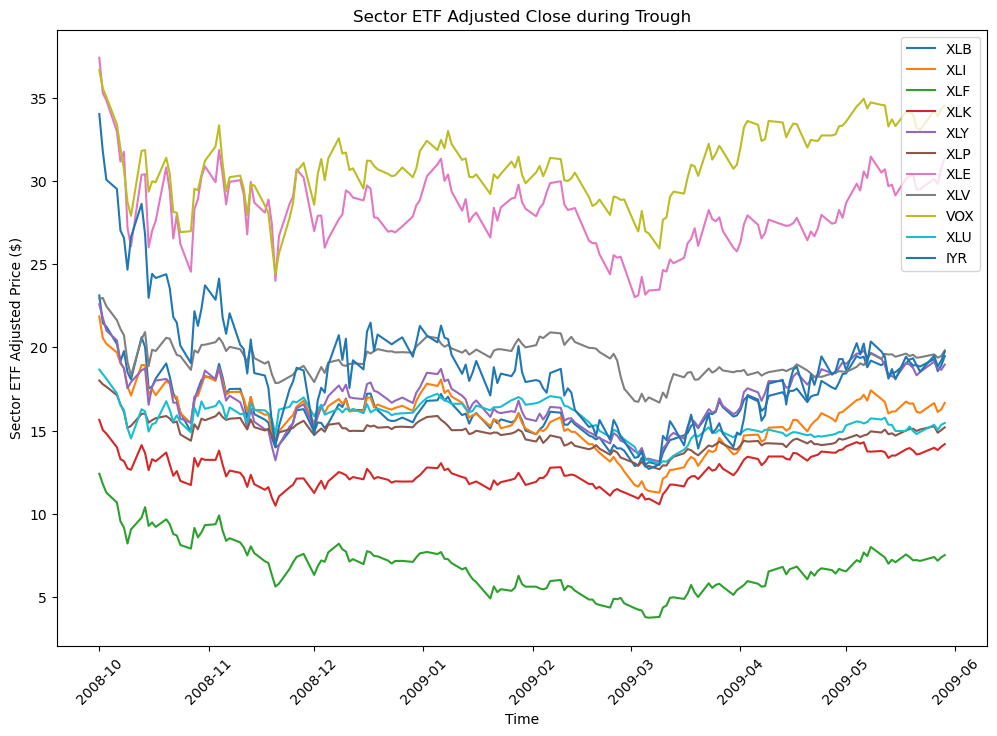

In [14]:
# a plot of adjusted close price of tickers during trough
plt.figure(figsize=(12,8))
for idx,ticker in enumerate(trough_adjusted_close.columns):
    plt.plot(trough_adjusted_close[ticker],label=f'{ticker}')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('Sector ETF Adjusted Price ($)')
plt.legend()
plt.title('Sector ETF Adjusted Close during Trough')

Observe that the stocks follow a relatively similar pattern as they are meant to be closer reflective of the whole market than an individual stock. However, there are clearly some periods of better investment than others, this is why the buy and hold strategy does not look to leave or re-enter an equity, it buys the equity and goes along for the bumpy ride.

## Stochastic Modeling
Stochastic modeling is a way to simulate the events over and over with changing parameters. In this case, changing the start date is going to be a useful way get a probability distribution function of the Sector ETFs when performing a passive buy and hold strategy.

Method:
1. Choose 1000 start dates 
2. Purchase a single stock
3. Hold onto the stock
4. Sell the stock at the end of the 90 day period
5. Record the ROI as a list in a nested dictionary 
6. Repeat 2-5 for each 1000 iterations

- Dependent variable: The return on investment 
- Independent variable: The start date
- Controlled variables:
  - 90 day investment period
  - Random days chosen
  - Same amount of stock bought/sold on the same start date

In [15]:
# save the nested dictionary of returnings for each ticker in each period using 10000 sample days across a 90 day investment period
period_return = stochastic_modeling(sector_etf_adjusted_close,sector_etf_tickers,economic_cycle_periods_list,1000,90)

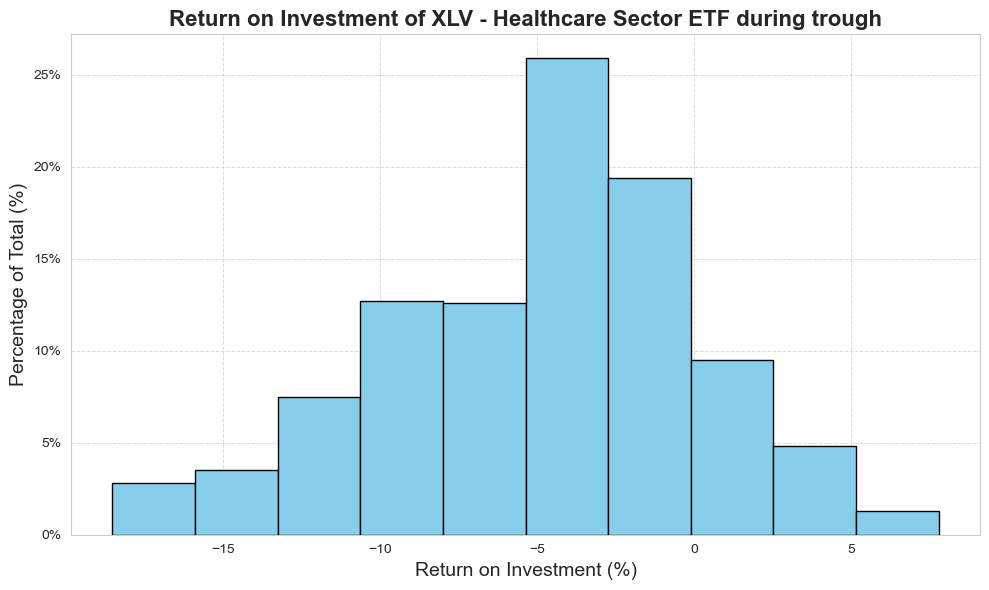

In [16]:
# plot the histogram of the XLV healthcare during a trough
plot_percentage_histogram(
    data=period_return['trough']['XLV'],
    title=f'Return on Investment of XLV - Healthcare Sector ETF during trough',
    xlabel='Return on Investment (%)',
        ylabel='Percentage of Total (%)'
)

There is now a distribution of results for each sector ETF during each economic period. By using the stochastic model it should have reduced the impact of when a stock was bought or sold. This has been seen above where the data is relatively normally distributed. This says a lot about the expected returns of data relative to its standard deviation. An extremely useful table is going to be one that looks at each of the expected returns from each sector ETF during each time period.

In [17]:
# get the average returns from the list of sectors during different time periods
buy_hold_returns = stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,period_return,'Mean')
buy_hold_returns

,trough,expansion,peak,contraction,all_data
XLB,-1.450417,5.2313,4.157667,0.469326,3.395294
XLI,-13.598458,6.820867,6.925401,-4.068082,3.872334
XLF,-22.734133,7.373985,9.722879,-15.232462,2.77475
XLK,3.09648,5.813605,12.691384,-2.705782,5.310741
XLY,-1.4005,7.201126,3.478558,-3.936603,3.827042
XLP,-8.400109,5.911997,5.244208,0.536941,3.177395
XLE,-5.146316,3.973645,-0.269629,4.389954,3.625424
XLV,-4.779411,9.264292,8.609723,-4.220295,3.49052
VOX,4.045237,5.470773,6.1666,-5.620801,2.893265
XLU,-8.739571,5.082058,6.317454,-2.647539,3.129543


This is a graphic that displays the success of each sector etf after running 1000 simulations of when to purchase the stock. 

In [25]:
# save the data so that it can be compared with other models later on
buy_hold_returns.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Financial Capstone Project/data/performance_data/buy_hold/buy_hold_average_return.csv')

In [19]:
buy_hold_returns.mean()

trough        -6.990988
expansion      6.042288
peak           6.123955
contraction   -2.963598
all_data       3.436819
dtype: float64

This represents the buy and hold strategy to strongly favor periods of economic growth.

In [20]:
std_average_return = stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,period_return,'Std')
std_average_return

,trough,expansion,peak,contraction,all_data
XLB,17.894068,5.328763,3.090327,10.71069,12.358497
XLI,12.202155,5.553742,3.283283,7.0087,11.699127
XLF,23.769176,5.668512,4.721586,6.837023,15.964867
XLK,13.007613,4.41614,5.527867,7.923457,11.192499
XLY,15.219249,5.269608,3.187478,6.170837,11.462037
XLP,5.882072,4.52649,1.551156,2.706438,6.20915
XLE,9.629669,8.929083,6.316032,14.99747,16.525884
XLV,5.15102,4.549998,5.745061,6.414576,7.567504
VOX,10.233738,5.227793,3.611101,7.113425,11.161857
XLU,4.663617,6.185501,2.048489,6.638304,7.877169


In [21]:
std_average_return.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Financial Capstone Project/data/buy_hold_standard_deviation.csv')

In [22]:
std_average_return.mean()

trough         12.382233
expansion       5.658180
peak            3.755029
contraction     7.726550
all_data       11.346732
dtype: float64

In [23]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output
import plotly.graph_objs as go
import pandas as pd
import yfinance as yf

# Create the app
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Create Plotly histogram
def create_stochastic_roi_histogram(data):
    return dcc.Graph(
        id='stochastic-roi-histogram',
        figure={
            'data': [
                go.Histogram(x=data, nbinsx=10, name='Stochastic ROI Histogram')
            ],
            'layout': go.Layout(
                title='Stochastic ROI Histogram',
                xaxis={'title': 'Stochastic ROI'},
                yaxis={'title': 'Frequency'},
                height=600
            )
        }
    )

def create_time_series_plot(x_data, y_data):
    return dcc.Graph(
        id='time-series',
        figure={
            'data': [
                go.Scatter(x=x_data, y=y_data, mode='lines', name='Value Over Time')
            ],
            'layout': go.Layout(
                title='Movement of Data Over Time',
                xaxis={'title': 'Date'},
                yaxis={'title': 'Value'},
                height=600
            )
        }
    )

# Create dropdown options
cycle_options = [{'label': period, 'value': period} for period in economic_cycle_periods_list]
ticker_options = [{'label': ticker, 'value': ticker} for ticker in sector_etf_tickers]

# Define the layout
app.layout = dbc.Container([
    # Dropdowns for cycle and ticker
    dbc.Row([
        dbc.Col(
            dcc.Dropdown(
                id='cycle-dropdown',
                options=cycle_options,
                value=economic_cycle_periods_list[0],  # Default value
                clearable=False,
                style={'margin-bottom': '20px'}
            ),
            width=6
        ),
        dbc.Col(
            dcc.Dropdown(
                id='ticker-dropdown',
                options=ticker_options,
                value=sector_etf_tickers[0],  # Default value
                clearable=False,
                style={'margin-bottom': '20px'}
            ),
            width=6
        ),
    ]),

    # Top 4/5 of the screen
    dbc.Row([
        dbc.Col(
            create_stochastic_roi_histogram(period_return['all_data'][sector_etf_tickers[0]]),  # Stochastic ROI histogram
            width=6,
            style={'height': '80vh', 'padding': '20px', 'backgroundColor': '#f9f9f9'}
        ),
        dbc.Col(
            create_time_series_plot(adj_close_sector_etf['all_data'].index, adj_close_sector_etf['all_data'][sector_etf_tickers[0]]),  # Movement of data
            width=6,
            style={'height': '80vh', 'padding': '20px', 'backgroundColor': '#f9f9f9'}
        ),
    ], style={'height': '80vh'}),

    # Bottom 1/5 of the screen (optional for additional content)
    dbc.Row([
        dbc.Col(
            html.Div("Additional content can go here."),
            width=12,
            style={'height': '20vh', 'padding': '20px', 'backgroundColor': '#f9f9f9'}
        ),
    ], style={'height': '20vh'}),
], fluid=True)

# Create callback to update graphs based on dropdown selections
@app.callback(
    Output('stochastic-roi-histogram', 'figure'),
    Output('time-series', 'figure'),
    Input('cycle-dropdown', 'value'),
    Input('ticker-dropdown', 'value')
)
def update_graphs(selected_cycle, selected_ticker):
    # Filter data based on selected_cycle and selected_ticker
    filtered_roi_data = period_return[selected_cycle][selected_ticker]  # Ensure you're accessing the right structure
    filtered_time_series_data = adj_close_sector_etf[selected_cycle][selected_ticker]

    # Update the stochastic ROI histogram
    histogram_fig = {
        'data': [
            go.Histogram(x=filtered_roi_data, nbinsx=10, name='Stochastic ROI Histogram')
        ],
        'layout': go.Layout(
            title=f'Stochastic ROI Histogram during {selected_cycle}',
            xaxis={'title': 'Return on Investment (%)'},
            yaxis={'title': 'Frequency'},
            height=400
        )
    }

    # Update the time series plot
    time_series_fig = {
        'data': [
            go.Scatter(x=filtered_time_series_data.index, y=filtered_time_series_data, mode='lines', name='Value Over Time')
        ],
        'layout': go.Layout(
            title=f'Adjusted Close Price during {selected_cycle}',
            xaxis={'title': 'Date'},
            yaxis={'title': 'Value'},
            height=400
        )
    }

    return histogram_fig, time_series_fig

# Run the app
if __name__ == '__main__':
    app.run_server(port=5500)

/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_36322/2436620662.py:2: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_36322/2436620662.py:3: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


### Conclusion
The buy and hold strategy is a simple yet effective strategy over the long term. However, it is clear that there are certain improvements that are made during different macreconomic cycles. During an expansion most stocks increase by a greater amount than during a constraction. The standard deviation also seems to be far greater during troughs which means that the expected return is much more volatile.

The full analysis can be found in the report.